# Proyecto Integrador Machine Learning I
### Autores
* Marian Alejandra Sierra Aranzazu
* 
*

# Contextualizacion del problema
* Problema:  Las tiendas en línea necesitan conocer a sus clientes para mejorar estrategias de retención, personalización de ofertas y previsión de ingresos
* Motivacion: Mejorar el valor de vida del cliente (CLV), reducir churn y aumentar ventas personalizadas.
* Usos: Fundamental para marketing dirigido, logística de inventario y diseño de campañas.
* Dataset: https://archive.ics.uci.edu/dataset/352/online+retail

# Exploracion y procesamiento

### Librerias

In [54]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


In [14]:
def missing_data(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum() / df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    
    return missing_data 

### EDA

In [11]:
df = pd.read_excel('Online Retail.xlsx')

In [13]:
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [16]:
len(df)

541909

In [15]:
missing_data(df)

,Total,Percent
CustomerID,135080,0.249267
Description,1454,0.002683
StockCode,0,0.000000
InvoiceNo,0,0.000000
Quantity,0,0.000000
InvoiceDate,0,0.000000
UnitPrice,0,0.000000
Country,0,0.000000


* 2% of the descriptions are null but this is not a blocker becuase we have the StockCode
* 24% of the Customer ID are nulls, we'll be deleting this records, we have enough data.

In [17]:
df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


In [29]:
df['Country'] = df['Country'].astype('category')

In [30]:
df = df[df['CustomerID'].notnull()]

In [20]:
display(df['StockCode'].value_counts())

StockCode
85123A    2313
22423     2203
85099B    2159
47566     1727
20725     1639
          ... 
85179a       1
23617        1
90214U       1
47591b       1
72802c       1
Name: count, Length: 4070, dtype: int64

### Top Products

<Axes: title={'center': 'Top 10 productos más vendidos'}, ylabel='Description'>

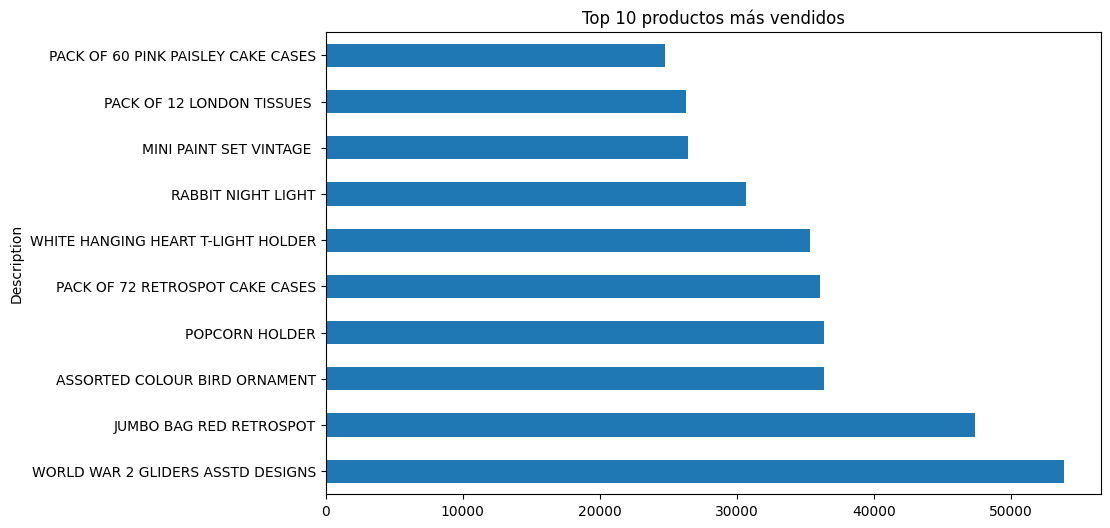

In [23]:
top_products = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)
top_products.plot(kind='barh', figsize=(10, 6), title='Top 10 productos más vendidos')

### Top Clientes

<Axes: title={'center': 'Top 10 clientes por monto total'}, xlabel='CustomerID'>

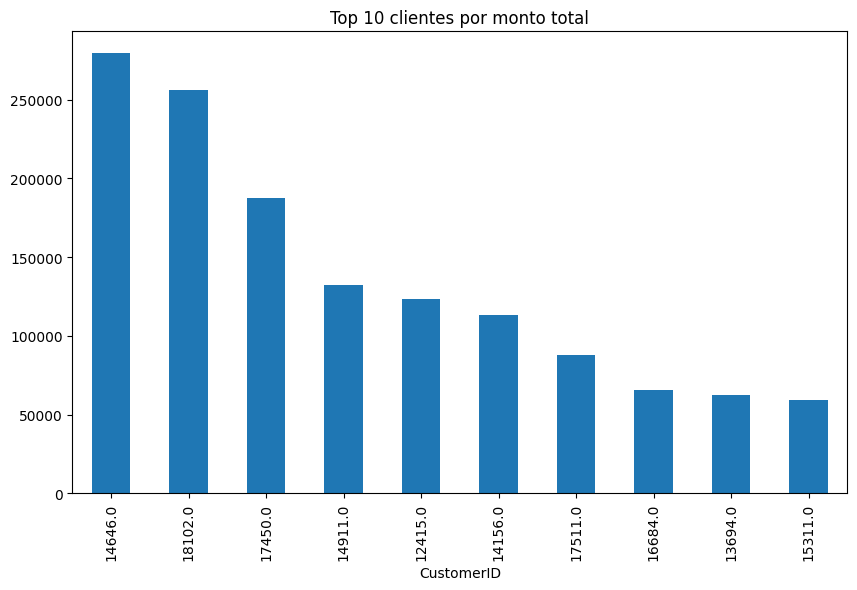

In [24]:
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
top_customers = df.groupby('CustomerID')['TotalPrice'].sum().sort_values(ascending=False).head(10)
top_customers.plot(kind='bar', figsize=(10, 6), title='Top 10 clientes por monto total')

<Axes: title={'center': 'Ventas semanales'}, xlabel='InvoiceDate'>

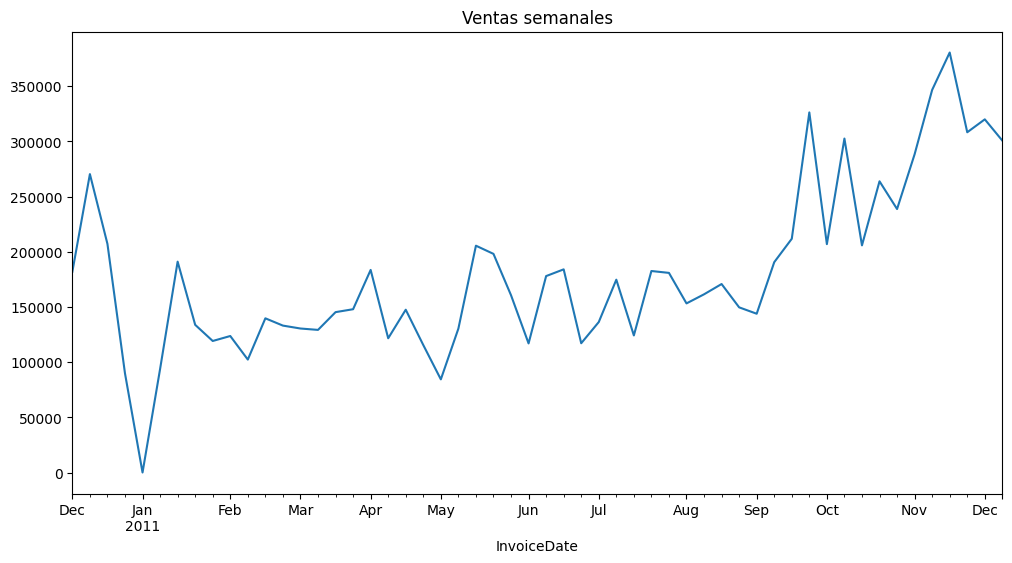

In [25]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df.set_index('InvoiceDate')['TotalPrice'].resample('W').sum().plot(figsize=(12,6), title='Ventas semanales')

### Chequear Outliers

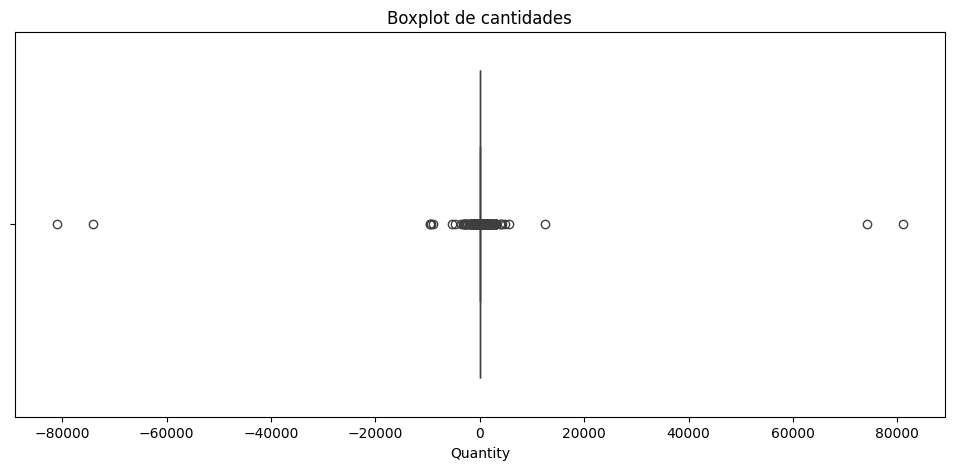

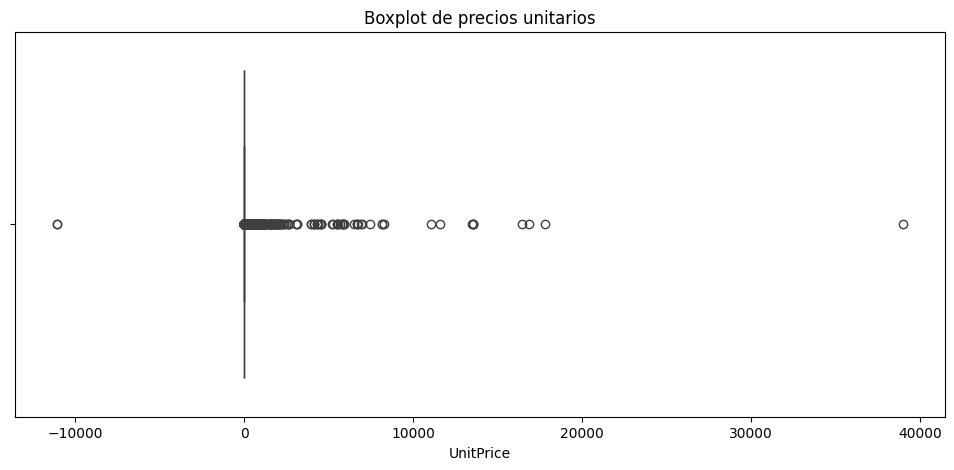

In [27]:
plt.figure(figsize=(12,5))
sns.boxplot(x=df['Quantity'])
plt.title('Boxplot de cantidades')
plt.show()

plt.figure(figsize=(12,5))
sns.boxplot(x=df['UnitPrice'])
plt.title('Boxplot de precios unitarios')
plt.show()

Tratamiento de outliers

In [31]:
# Definir los percentiles
q_low = df['Quantity'].quantile(0.025)
q_high = df['Quantity'].quantile(0.975)

p_low = df['UnitPrice'].quantile(0.025)
p_high = df['UnitPrice'].quantile(0.975)

# Filtrar
df = df[(df['Quantity'] >= q_low) & (df['Quantity'] <= q_high)]
df = df[(df['UnitPrice'] >= p_low) & (df['UnitPrice'] <= p_high)]

### RFM

In [34]:
snapshot_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
})
rfm.columns = ['Recency', 'Frequency', 'Monetary']

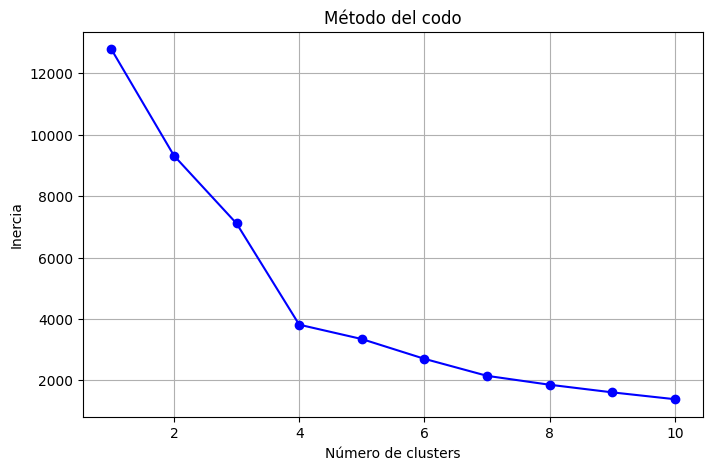

In [ ]:
# Normalización
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

# Reducción de dimensiones para visualización (opcional)
pca = PCA(n_components=2)
pca_rfm = pca.fit_transform(rfm_scaled)

# Convertir a DataFrame escalado
rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=rfm.columns, index=rfm.index)

# Seleccionar columnas correctamente (asegúrate que estas son las que tienes en rfm)
X = rfm_scaled_df[['Recency', 'Frequency', 'Monetary']]

# Calcular inercia para cada valor de k
inertia = []
K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Graficar método del codo
plt.figure(figsize=(8, 5))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Número de clusters')
plt.ylabel('Inercia')
plt.title('Método del codo')
plt.grid(True)
plt.show()


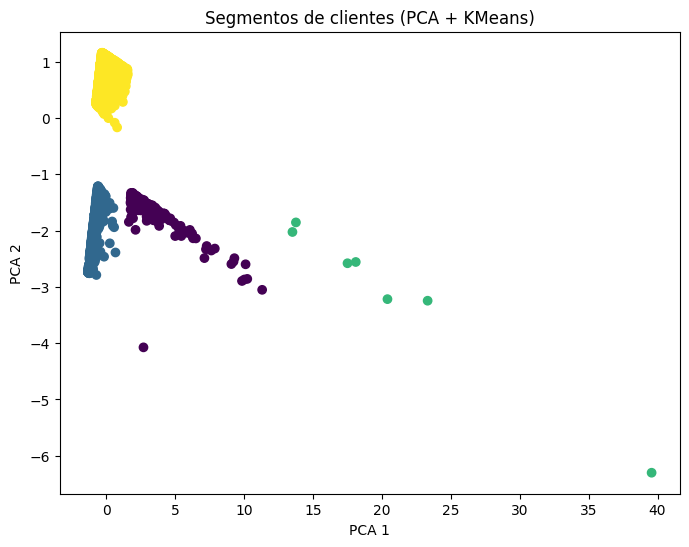

In [45]:
# K-Means
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X)

# Visualización
plt.figure(figsize=(8,6))
plt.scatter(pca_rfm[:,0], pca_rfm[:,1], c=clusters, cmap='viridis')
plt.title('Segmentos de clientes (PCA + KMeans)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

# Añadir clusters al dataframe
rfm['Cluster'] = clusters

In [ ]:
silhouette_avg = silhouette_score(X, clusters)
print(f"Silhouette Score: {silhouette_avg:.2f}")

Silhouette Score: 0.59


In [46]:
rfm.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean().round(2)

,Recency,Frequency,Monetary
Cluster,,,
0,12.96,20.72,8612.92
1,247.57,1.54,400.94
2,3.00,115.57,55388.25
3,43.49,3.60,1122.89


In [47]:
rfm['Cluster'].value_counts().sort_index()

Cluster
0     216
1    1056
2       7
3    2983
Name: count, dtype: int64

C:\Users\maria\AppData\Local\Temp\ipykernel_25044\2322254341.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Cluster', y=var, data=cluster_summary, ax=axes[i], palette=colors)
C:\Users\maria\AppData\Local\Temp\ipykernel_25044\2322254341.py:12: UserWarning: 
The palette list has fewer values (3) than needed (4) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x='Cluster', y=var, data=cluster_summary, ax=axes[i], palette=colors)
C:\Users\maria\AppData\Local\Temp\ipykernel_25044\2322254341.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Cluster', y=var, data=cluster_summary, ax=axes[i], palette=colors)
C:\Users\maria\AppData\Local\Temp\ipykernel_25044\2

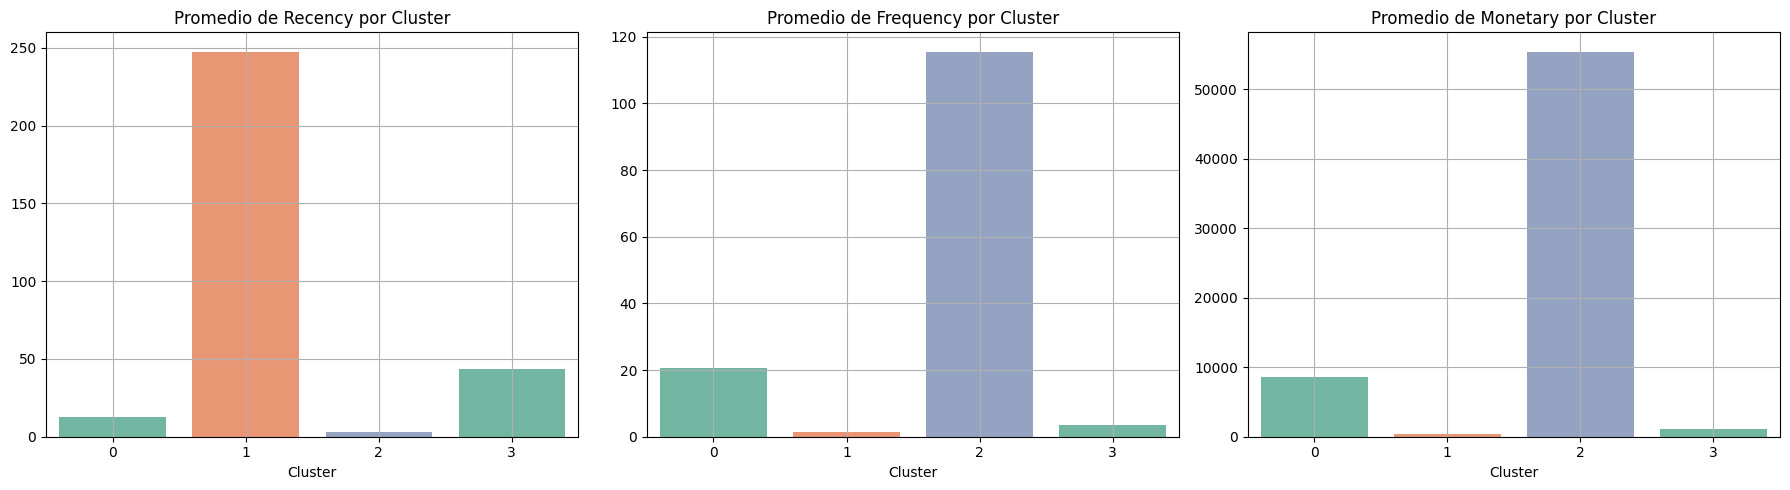

In [49]:
# Agrupamos y calculamos promedio por cluster
cluster_summary = rfm.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean().reset_index()

# Crear subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Variables a graficar
variables = ['Recency', 'Frequency', 'Monetary']
colors = ['#66c2a5', '#fc8d62', '#8da0cb']

for i, var in enumerate(variables):
    sns.barplot(x='Cluster', y=var, data=cluster_summary, ax=axes[i], palette=colors)
    axes[i].set_title(f'Promedio de {var} por Cluster')
    axes[i].set_ylabel('')
    axes[i].set_xlabel('Cluster')
    axes[i].grid(True)

plt.tight_layout()
plt.show()

# Construccion de Modelos

### XGBoost Regresion sobre AOV

In [56]:
from sklearn.metrics import mean_squared_error, r2_score

# Regresión con XGBoost
X = rfm[['Recency', 'Frequency']]
y = rfm['Monetary']

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Crear el modelo XGBoost para regresión
xgb_regressor = xgb.XGBRegressor(random_state=42)
xgb_regressor.fit(X_train, y_train)

# Predicción
y_pred = xgb_regressor.predict(X_test)

# Evaluación
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R^2 Score:", r2_score(y_test, y_pred))

Mean Squared Error: 11506885.274521163
R^2 Score: -0.15214768220096042


# Validacion

# Propuesta

# Reflexion